In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
import scipy as sc
import time
from functools import reduce

import tensorflow as tf
from tensorflow import keras

import rl_env

In [2]:
def create_environment(game_type='Hanabi-Full', num_players=2):
  """Creates the Hanabi environment.

  Args:
    game_type: Type of game to play. Currently the following are supported:
      Hanabi-Full: Regular game.
      Hanabi-Small: The small version of Hanabi, with 2 cards and 2 colours.
    num_players: Int, number of players to play this game.

  Returns:
    A Hanabi environment.
  """
  return rl_env.make(
      environment_name=game_type, num_players=num_players, pyhanabi_path=None)

In [3]:
def create_actor_lstm(num_actions, state_shape, num_steps, num_trajectories, num_layers=2, num_units=512):
    
    x = tf.placeholder(tf.float32, shape=[None, None,state_shape], name='x')
    actions = tf.placeholder(tf.float32, shape=[None,num_actions], name='actions')
    
    cells = [tf.keras.layers.LSTMCell(num_units), tf.keras.layers.LSTMCell(num_units)]
    outputs = keras.layers.RNN(cells, return_sequences=False)(x)
    
    logits = tf.layers.dense(outputs, units=num_actions, activation=None)
    y = tf.nn.softmax(logits)
    
    negative_log_prob = tf.nn.softmax_cross_entropy_with_logits_v2(labels=actions, logits=logits)
    
    advantage = tf.placeholder(tf.float32, shape=[None,], name='advantage')
    
    loss = tf.reduce_mean(negative_log_prob*advantage)#tf.reduce_mean(tf.multiply(negative_log_prob, advantage))
    optimizer = tf.train.AdamOptimizer(0.1)
    train = optimizer.minimize(loss)
    
    return y, x, train, loss, advantage, actions, negative_log_prob, outputs, logits

def create_actor_mlp_lstm(num_actions, state_shape, num_steps="UNUSED", num_trajectories="UNUSED", num_layers="UNUSED", num_units=512):
    
    x = tf.placeholder(tf.float32, shape=[None, None,state_shape], name='x')
    actions = tf.placeholder(tf.float32, shape=[None,num_actions], name='actions')
    
    h1 = tf.layers.dense(x, units=num_units, activation=tf.nn.relu)
    cells = [tf.keras.layers.LSTMCell(num_units), tf.keras.layers.LSTMCell(num_units)]
    outputs = keras.layers.RNN(cells, return_sequences=True)(h1)
    
    logits = tf.layers.dense(outputs, units=num_actions, activation=None)
    y = tf.nn.softmax(logits)
    
    logits_flat = tf.reshape(logits,(-1, num_actions))
    negative_log_prob = tf.nn.softmax_cross_entropy_with_logits_v2(labels=actions, logits=logits_flat)
    
    advantage = tf.placeholder(tf.float32, shape=[None,], name='advantage')
    
    loss = tf.reduce_mean(negative_log_prob*advantage)#tf.reduce_mean(tf.multiply(negative_log_prob, advantage))
    optimizer = tf.train.AdamOptimizer()
    train = optimizer.minimize(loss)
    
    return y, x, train, loss, advantage, actions#, negative_log_prob, outputs, logits_flat

def create_critic_model(state_shape, num_units=512):
    model = keras.Sequential([
        keras.layers.Dense(num_units, input_dim=state_shape, activation=tf.nn.relu),
        keras.layers.Dense(num_units, activation=tf.nn.relu),
        keras.layers.Dense(1)
    ])
    adamOpt = keras.optimizers.Adam(0.00001)
    model.compile(loss='mean_squared_error',
                optimizer=adamOpt,
                metrics=['mean_squared_error'])
    return model

In [ ]:
y, x, train, loss, advantage, actions, negative_log_prob, outputs, logits = create_actor_mlp_lstm(3, 10, 5, 10)
#y, x, train, loss, advantage, actions = create_actor_mlp_lstm(3, 10, 5, 10)
y, x, train, loss, advantage, actions, negative_log_prob, outputs, logits

In [ ]:
y, x, train, loss, advantage, actions, negative_log_prob, outputs, logits = create_actor_mlp_lstm(3, 10, 5, 10)
#y, x, train, loss, advantage, actions = create_actor_mlp_lstm(3, 10, 5, 10)
y, x, train, loss, advantage, actions, negative_log_prob, outputs, logits

In [ ]:
init = tf.global_variables_initializer()

sess = tf.Session()
sess.run(init)

In [ ]:
xx = np.random.choice([0,1,2], (10))
#xx = xx.reshape((10,5,-1,7))
xx.shape
create_environment()

In [ ]:
sess.run(y, {x: [[xx]]}).squeeze()

In [4]:
def get_action(sess, y, x, state, legal_moves):
    policy = sess.run(y, {x: [[state]]}).squeeze()
    # somehow only consider the legal actions
    policy_legal = np.full(policy.shape, -np.inf)
    policy_legal[legal_moves] = policy[legal_moves]
    policy_legal = sc.special.softmax(policy_legal)
    
    action = np.random.choice(policy_legal.shape[0], p=policy_legal)
    logprob = np.log(policy_legal[action])
    
    return action, logprob

def get_value_estimate(critic, state):
    return critic.predict(np.reshape(state, (1,-1))).squeeze()
    

In [5]:
def calculate_discounted_rewards(rewards, ep_lens, gamma=0.99):
    Rts = np.zeros(rewards.shape)
    
    for traj in range(len(rewards)):
        Rt = 0
        T = int(ep_lens[traj])
        for t in reversed(range(T)):
            Rt += rewards[traj][t]
            Rts[traj][t] = Rt
            
            Rt *= gamma
            
    return Rts

In [ ]:
#actor = create_actor_model(env.num_moves(), env.vectorized_observation_shape()[0])
#critic = create_critic_model(env.vectorized_observation_shape()[0])
#rnn = create_actor_lstm(0, 658, 10, 50)
#actor.summary()
#critic.summary()

In [ ]:
num_iterations = 1
num_trajectories = 1000
t0 = time.time()


for it in range(num_iterations):
    rewards = np.zeros((num_trajectories, 110))
    ep_lens = np.zeros(num_trajectories).astype(int)


    # collect trajectories
    for traj in range(num_trajectories):
        # reset environment
        observations = env.reset()
        reward = 0
        is_done = False

        # collect one trajectory
        for st in range(110):
            # extract legal moves and state from observations
            moves = observations['player_observations'][st % 2]['legal_moves_as_int']
            state = observations['player_observations'][st % 2]['vectorized']

            # get next action
            action, _ = get_action_NEW(sess, y, x, state, moves)

            # do next step
            observations, reward, is_done, _ = env.step(action)

            # store reward after executing action
            rewards[traj, st] = reward


            if (is_done or st == 110-1):
                ep_lens[traj] = st
                #print("Done", ep, st)
                #print(observations['player_observations'][0]['pyhanabi'])
                #print('reward', reward)
                #print(' --- ')
                break

    
t1 = time.time()
print(rewards.shape, ep_lens.shape, t1-t0)

In [ ]:
np.min(rewards, axis=1).mean()

In [6]:
NUM_ITERATIONS = 300
NUM_TRAJECTORIES = 20
NUM_STEPS = 5
MAX_EPISODE_LENGTH = 110
t0 = time.time()

# create hanabi environment
env = create_environment()
# init simple keras critic 
critic = create_critic_model(env.vectorized_observation_shape()[0])
# init actor neural net (a custom tf graph)
y, x, train, loss, advantage, actions = create_actor_mlp_lstm(env.num_moves(), env.vectorized_observation_shape()[0])
init = tf.global_variables_initializer()

sess = tf.Session()
sess.run(init)

losses = []
for it in range(NUM_ITERATIONS):
    if(it % 10 == 0):
        tt = time.time()
        print('iteration #', it, ', time passed: ', tt-t0)
    
    actions_ = np.zeros((NUM_TRAJECTORIES, 110, env.num_moves())) 
    states = np.zeros((NUM_TRAJECTORIES, 110, env.vectorized_observation_shape()[0]))
    rewards = np.zeros((NUM_TRAJECTORIES, 110))
    baselines = np.zeros((NUM_TRAJECTORIES, 110))
    logprobs = np.zeros((NUM_TRAJECTORIES, 110))
    ep_lens = np.zeros(NUM_TRAJECTORIES)


    # collect trajectories
    for traj in range(NUM_TRAJECTORIES):
        # reset environment
        observations = env.reset()
        reward = 0
        is_done = False
        i = 0
                       
        # collect one trajectory
        while(not is_done):
            # extract legal moves and state from observations
            moves = observations['player_observations'][i % 2]['legal_moves_as_int']
            state = observations['player_observations'][i % 2]['vectorized']

            # get next action
            action, logprob = get_action(sess, y, x, state, moves)

            # store variables
            actions_[traj, i, action] = 1
            states[traj, i] = state

            # get baseline(value estimate)
            baselines[traj, i] = get_value_estimate(critic, state)

            # do next step
            observations, reward, is_done, _ = env.step(action)

            # store reward after executing action
            rewards[traj, i] = reward

            i += 1
        ep_lens[traj] = i
    
    # collected a bunch of trajectories, now calculate discounted rewards (Rts)
    Rts = calculate_discounted_rewards(rewards, ep_lens)
    max_ep_len = np.max(ep_lens)
    num_batches = np.ceil(max_ep_len/NUM_STEPS).astype(int)
    for i in range(num_batches):
        start = i * NUM_STEPS
        end = start + NUM_STEPS
        idx = ep_lens > start
        
        x_batch = states[idx,start:end]
        rew_batch = Rts[idx,start:end]
        adv_batch = rew_batch - baselines[idx,start:end]
        acts_batch = actions_[idx,start:end]
    
        _, loss_i = sess.run((train, loss), {x: x_batch, advantage: rew_batch.flatten(), actions: np.reshape(acts_batch, (-1, env.num_moves()))})
        losses.append(loss_i)
    
    
    
    # 'flatten' the lists
    #x_train = np.array(reduce(lambda x,y: np.vstack((x,y)), states))
    #adv = np.array(reduce(lambda x,y: np.hstack((x,y)), Ats))
    #adv -= adv.mean()
    #adv /= adv.std() + 10**-10
    #rew = np.array(reduce(lambda x,y: np.hstack((x,y)), Rts))
    #acts = np.array(reduce(lambda x,y: np.vstack((x,y)), actions_))
    
    # train critic and actor
    
    #critic.train_on_batch(x_train, rew)
    #rew -= rew.mean()
    #rew /= rew.std() + 10**-10
        
    
    
    #_, loss_t = sess.run((train, loss), {x: x, advantage: rew, actions: acts})
    #losses.append(loss_t)
    
    
t1 = time.time()
print(len(rewards), len(ep_lens), len(losses), t1-t0)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Use keras.layers.dense instead.
iteration # 0 , time passed:  3.3727402687072754
iteration # 10 , time passed:  52.40503692626953
iteration # 20 , time passed:  121.44902729988098
iteration # 30 , time passed:  188.61777710914612
iteration # 40 , time passed:  257.29908299446106
iteration # 50 , time passed:  328.39046478271484
iteration # 60 , time passed:  397.30139446258545
iteration # 70 , time passed:  466.2092852592468
iteration # 80 , time passed:  528.3286347389221
iteration # 90 , time passed:  596.00958776474
iteration # 100 , time passed:  665.5602443218231
iteration # 110 , time passed:  739.3621141910553
iteration # 120 , time passed:  816.0345356464386
iteration # 130 , time passed:  892.6777145862579
iteration # 140 , time passed:  975.1077353954315
iteration # 150 , time passed:  1034.737031698227
iteration # 160 , time passe

In [ ]:
sess.close()

In [ ]:
observations = env.reset()
state = observations['player_observations'][0]['vectorized']
critic.predict(np.reshape(state, (1,-1))).squeeze()

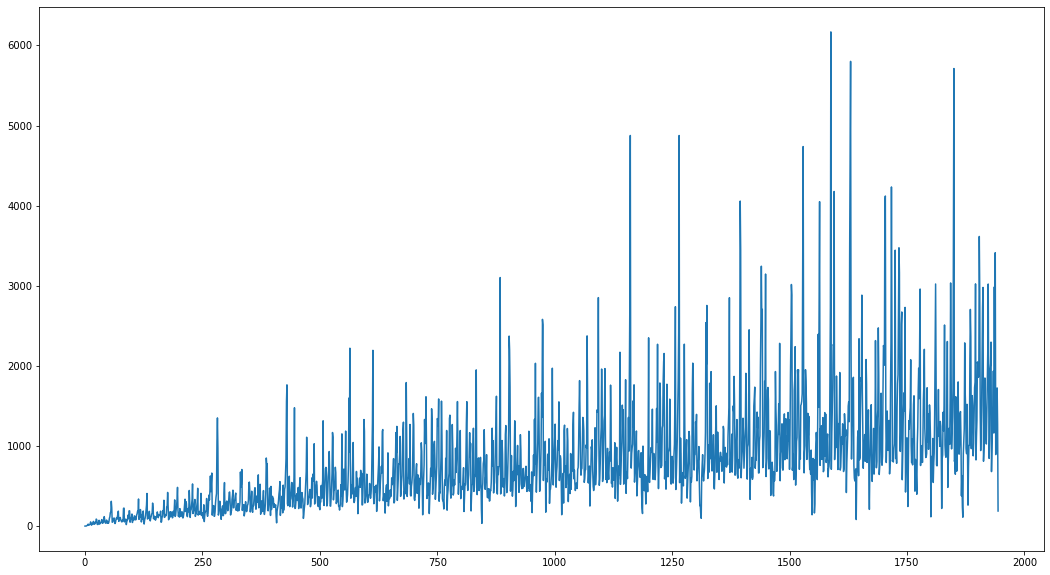

In [7]:
plt.figure(0, (18,10))
plt.plot(list(map(lambda x: -x,losses)))
plt.show()

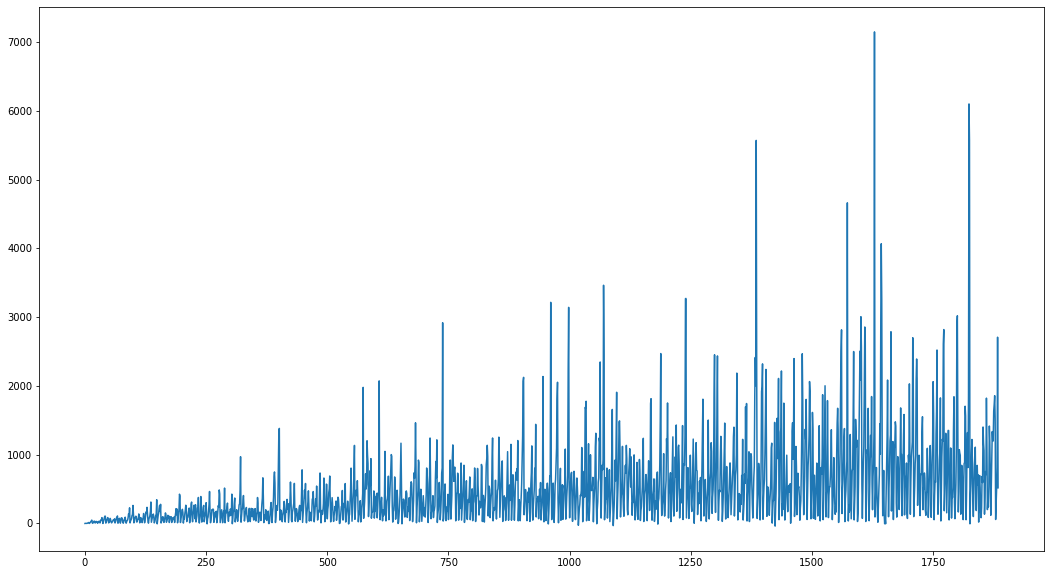

In [7]:
plt.figure(0, (18,10))
plt.plot(list(map(lambda x: -x,losses)))
plt.show()

In [ ]:
a = np.array([[[1,1],[2,2],[3,3]], [[4,4],[5,5]], [[6,6]]])
b = np.array([3,2,1])
aa = np.zeros((3,3,2))
aa[0] = a[0]
aa[1,0:2] = a[1]
aa[2,0:1] = a[2]
#print(list(map(lambda x: x[-len(x)+2], a)))
for i in range(3):
    r = b > i*3
    print(r)
    print(aa[r,i])
    print()
ii = np.ceil(96/5)
(ii-1)*5, (ii-1)*5+5